In [1]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as ss
from scipy.optimize import minimize 

from sklearn.model_selection import train_test_split,cross_val_score, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *

# notebook settings
plt.rcParams["figure.figsize"] = (10,5)
pd.set_option('max_columns', 29)

In [2]:
# read and save the sentence length data in a dataframe
df = pd.read_csv('QuietDonSentenceLengths.csv', header=None)

print(df.shape)
df.head(5)

(3760, 1)


,0
0,6
1,25
2,12
3,10
4,16


In [3]:
# data is a variable the contains the sentence length observations as arrays
data = df.values; data[:5]

array([[ 6],
       [25],
       [12],
       [10],
       [16]])

### Key concepts of MLE

Maximium Likelihood Estimation (MLE) is a statistical method used for estimating the parameters of a presumed probability distribution given some data generated from a random process. This is accomplished by maximising the likelihood function and calculating parameters of the distribution that best explain the generated data.

For a continuous random variable, the likelihood function is the Probability Density Function (PDF) and for a discrete random variable, the likelihood function is the probability mass function (PMF). The parameter of a distribution is estimated by maximizing the likelihood or probability distribution and this parameter is **fixed**.

#### Estimating the parameter of the poisson distribution, lambda 𝜆 using MLE

The Poisson distribution models the number of occurences of an event at a fixed or constant rate. For this task, the aim is to model the number of words per sentence using a Poisson distribution. This distribution only has one parameter lambda, $\lambda$ which represents the rate. $\lambda$ is equal to the sample mean and variance. $\lambda$ must be greater than zero.

$$Expectation = \lambda$$
$$Variance = \lambda$$

Hence the parameter, $\lambda$ is estimated below by minimizing the $nll\_poisson$ function (or maximizing the likelihood function), with $1$ as the initial guess and applying Powell minimization method

In [4]:
def nll_poisson(lambda_):
    ''' This function return the sum of the loglikelihoods for the Poisson distribution
        It takes lambda_, 𝜆 as the only parameter of the Poisson distribution
    '''
    neg_loglikelihood = -ss.poisson.logpmf(k=data, mu=lambda_).sum()
    return neg_loglikelihood 

# minimizing the negative loglikelihood function
intial_guess = 1
result = minimize(nll_poisson,              # function to minimize
                  x0=intial_guess,          # start value for parameter, lambda_
                  method='Powell')          # minimization method

# extracts the value of lambda_ from the result variable, as result contains different values,                   
MLE_lambda= result.x[0]
print('The estimated value of the parameter, 𝜆 is: ', MLE_lambda)
print('The sample mean of the observed data is: ', np.mean(data))
print('The sample variance of the observed data is: ', np.var(data, ddof=1))

The estimated value of the parameter, 𝜆 is:  12.673138305460778
The sample mean of the observed data is:  12.67313829787234
The sample variance of the observed data is:  83.24801462306068


The parameter, $\lambda$ of the Poisson distribution is the same as the sample mean of the observations but the sample variance is greater than the variance of the Poisson distribution by a factor of about 6.5, It can be assumed that the Poisson distribution is not a good fit for the sentence length data, however, plotting the distribution and comparing with the sentence length histogram will provide more evidence.

#### Fitting a Poisson distribution to the sentence length data using the estimated value of lambda

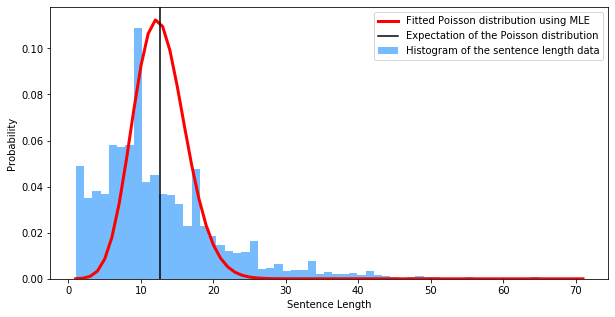

In [5]:
# generate integer values from 1 to 70. NB:Poisson only takes discrete values
x_range = np.linspace(1, 71, 71)
# histogram plot of the sentence length data
plt.hist(data, density=True, bins='auto', label='Histogram of the sentence length data', color= 'xkcd:sky blue')
# a plot of the fitted poisson distribution using the estimated parameter, lambda_
plt.plot(x_range, ss.poisson.pmf(x_range, mu=MLE_lambda), 'r-', lw=3, label='Fitted Poisson distribution using MLE')
# indicates the expectation of the Poisson distribution
plt.axvline(MLE_lambda, color='k', label='Expectation of the Poisson distribution')

# displays the legend
plt.legend()
# labelling the x and y axes
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.show()

Measuring the performance of the model using AIC and BIC

In [17]:
#AIC for Poisson distribution
poisson_ll = np.sum(ss.poisson.logpmf(k=data, mu=MLE_lambda))
k = 1
poisson_AIC = 2*k - 2*poisson_ll; poisson_AIC 

37206.867064372665

In [18]:
#BIC for Poisson distribution
n = len(data)
poisson_BIC = k*np.log(n) - 2*poisson_ll; poisson_BIC

37213.09923860905

It can be seen from the plot above that the Poisson distribution does not fit the sentence length data properly. This implies that the Poisson distribution is not the underlying distribution of the sentence length data.

The parameter, 𝜆 has been estimated using the MLE. The sentence length data was used as input and the output is the Probability Mass Function (PMF) of the Poisson distribution plotted in red, that is the probability of observing the sentence lengths

### Negative Binomial Distribution
The Negative Binomial distribution is the distribution of the number of trials required to obtain a certain number of successes in repeated independent Bernoulli trials.
The parameters of the negative binomial distribution are $n$ and $p$. $n$ is the number of sucesses, $p$ is the probability of a single success, the random variable is the number of independent Bernoulli trials and $1-p$ is the probability of a single failure.

The code block below estimates the parameters, $n$ and $p$ of the negative binomial distribution by minimizing the negative loglikelihood (ie maximizing the likelihood). 

The $nll\_nbinorm$ function returns the sum of the negative loglikelihood of the negative binomial distribution.
The $minimize$ function in the Scipy library requires us to set the initial guess for the parameters to be estimated. Accordingly, $initial\_n = 1$ and $intial\_p = np.finfo(np.float).eps$ representing the initial values for $n$ and $p$ repectively. Also, ($initial\_n$, None) and ($initial\_p$, 1) were used as boundaries for n and p respectively. The search space for $n$ is between one and any integer value. $p$ cannot be less than or equal to zero and cannot be greater than one.

#### Estimating the parameters of the Negative Binomial distribution, n and p

The estimated parameter, p representing the probability of a single success is:  0.17344807339843893
The estimated parameter, n representing the number of successes is:  2.652468430395774


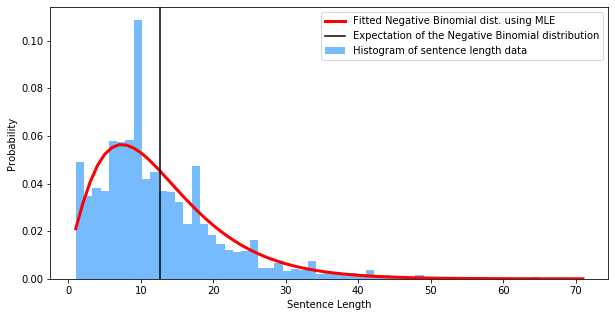

In [7]:
# using scipy to estimate the parameters of the negative binomial distribution

def nll_nbinorm(params):
    ''' This function returns the sum of the loglikelihoods of the negative binomial distribution.
        It takes n, number of successes and p, probability of a single success as parameters
    '''
    # n is assigned the first position on the params list and p the second position
    n, p = params[0], params[1]
    # neg_loglikelihood is the sum of the loglikehoods of the negative binomial distribution
    neg_loglikelihood = -ss.nbinom.logpmf(k=data, n=n, p=p).sum()
    return neg_loglikelihood

# this is the initial values for n and p parameters
initial_n = 1
intial_p = np.finfo(np.float).eps

# setting boundaries (ie lower and upper limits) for the distribution parameters
bounds = [(initial_n, None), (intial_p, 1)]

# minimizing the negative loglikelihood function so as to compute the estimates of n and p.
optim = minimize(nll_nbinorm,
                 x0=(initial_n, intial_p),
                 method='Powell',
                 bounds=bounds)

MLE_p = optim.x[1]                  # estimated probability of a single success
MLE_n = optim.x[0]                  # estimated number of successes 
nbin_mu = MLE_n*(1-MLE_p)/MLE_p     # expectation of the distribution

print('The estimated parameter, p representing the probability of a single success is: ', MLE_p)
print('The estimated parameter, n representing the number of successes is: ', MLE_n)

# generate integer values from 1 to 70
x_plot = np.linspace(1, 71, 71)
# histogram plot of the sentence length data
plt.hist(data, density=True, bins='auto', color='xkcd:sky blue', label='Histogram of sentence length data')
# a plot of the fitted negative binomial distribution using the estimated parameters, n and p
plt.plot(x_plot, ss.nbinom.pmf(x_plot, n=MLE_n, p=MLE_p), 'r-', lw=3, 
         label='Fitted Negative Binomial dist. using MLE')
plt.axvline(nbin_mu, color='k', label='Expectation of the Negative Binomial distribution')
# labelling the x and y axes
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [23]:
#AIC for negative binomial distribution
negbinorm_ll = np.sum(ss.nbinom.logpmf(k=data, n=MLE_n, p=MLE_p))
k = 2
negbinorm_AIC = 2*k - 2*negbinorm_ll; negbinorm_AIC

25706.538244525887

In [26]:
#BIC
n = len(data)
k = 2
negbinorm_BIC = k*np.log(n) - 2*negbinorm_ll; negbinorm_BIC

25719.002592998655

In [8]:
# computing the mean and variance of the nbinom distribution using the MLE estimates n and p
nb_mean, nb_var, _, _ = ss.nbinom.stats(MLE_n, MLE_p, moments='mvsk')
print('The mean of the negative binormial distribution is: ', round(nb_mean.tolist(), 2))
print('The variance of the negative binormial distribution is: ', round(nb_var.tolist(), 2))

The mean of the negative binormial distribution is:  12.64
The variance of the negative binormial distribution is:  72.88


The negative binomial distribution and Poisson distribution are used to model discrete random variables but for this task, the negative binomial distribution fits the sentence length data reasonably well and better than the Poisson distribution.

The parameters, $n$ and $p$ have been estimated using the MLE and these parameters define the negative binomial distribution plotted above. The sentence length data was used as input and the output is the Probability Mass Function (PMF) of the negative binomial distribution plotted in red, that is the probability of observing the sentence lengths.

#### Discussing the results of the two distributions

As stated earlier, the value of the parameter of a Poisson distribution, lambda (which represents the rate) is same as the expectation and variance of the distribution. It was observed that the sentence length data has a mean (ie sample mean) of 12.673 and variance (ie sample variance) of 83.248, although the estimated value of lambda is equal to the sample mean but the sample variance is far away by a factor of about 6.5.

The expectation and variance of the negative binomial distribution are 12.640 and 72.875 resepectively. It can be seen that the sample mean and sample variance are very close to the expectation and variance of the negative binomial distribution respectively. This is an evidence that the negative binomial distribution is a better fit for the sentence length data than the Poisson distribution.

Additionally, the AIC and BIC scores for Negative Binormial distribution is lower than the Poisson distribution and lower AIC and BIC implies better fit.

In [9]:
# Dataframe showing the sample mean and variance of the sentence length data
pd.DataFrame(data={'Sample mean': [np.mean(data)], 'Sample variance': [np.var(data, ddof=1)]}).round(3)

,Sample mean,Sample variance
0,12.673,83.248


In [10]:
# Dataframe showing the expectation and variance of the negative binormial and Poisson distributions
pd.DataFrame(data={'Statistic':['Expectation','Variance'], 
                   'nbinorm':[nb_mean.tolist(), nb_var.tolist()], 
                   'Poisson':[MLE_lambda, MLE_lambda]}).round(3)

,Statistic,nbinorm,Poisson
0,Expectation,12.640,12.673
1,Variance,72.875,12.673


### MAP Inference
#### Key concepts of MAP inference

The main idea behind MAP inference is to merge two distributions (prior and likelihood) into a "more robust" distribution (posterior) and keep updating the probability as more data is collected. 

The posterior is more robust because the Maximum Likelihood Estimate (MLE) does not incorporate prior knowledge or a guess about the distribution before seeing the data. 

The parameters in MAP inference are random variables and **not fixed**, contrary the MLE where the parameters are fixed.

#### Plotting the gamma distribution and estimating the parameter of the posterior

For this task, the parameter of the posterior, lambda, is estimated by maximizing the posterior given the data.

Gamma is given as the prior distribution for this task. The gamma distribution is a continuous distribution with parameters alpha, $\alpha$ - shape parameter and beta, $\beta$. The scale = 1 / $\beta$

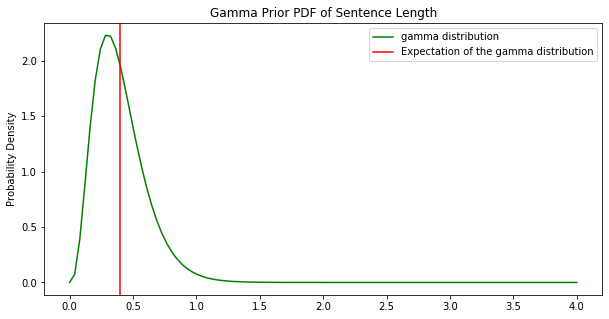

The lambda parameter of the Poisson distribution is:  12.673138305460778
The lambda parameter of the Posterior is:  12.640318311205874


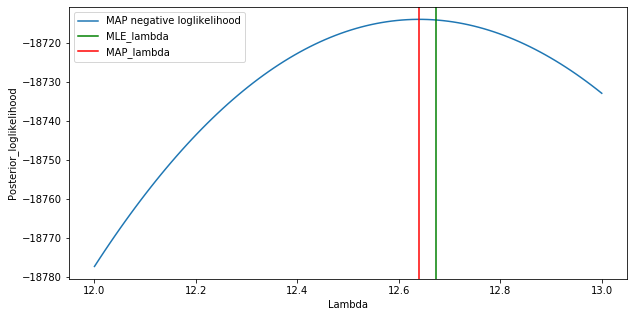

In [11]:
shape, scale = 4.0, 0.1            # parameters of the gamma distribution
x_plot = np.linspace(0,4,100)      # generates 100 real values from 0 to 4

# probability density function of the prior gamma distribution with given parameters
gamma_ys = ss.gamma.pdf(x_plot, a=shape, loc=0, scale=scale)
# plot of the gamma distribution
plt.plot(x_plot, gamma_ys, 'g-', label='gamma distribution')
plt.title('Gamma Prior PDF of Sentence Length')
# expectation of the PDF (prior gamma distribution)
plt.axvline(shape/(1/scale), color='red', label='Expectation of the gamma distribution')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# Fit a Poisson distribution to the sentence length using a gamma distribution prior
def map_ll(lambda_): 
    ''' This function returns the posterior and takes in lambda_, the posterior parameter.
    '''
    loglikelihood = np.sum(ss.poisson.logpmf(k=data, mu=lambda_))
    prior = ss.gamma.logpdf(lambda_, a=shape, loc=0, scale=scale)
    posterior = -(loglikelihood + prior)
    return posterior

initial_guess = 1            
result = minimize(map_ll,               # the posterior probability function to be minimized
                  x0=initial_guess,     # inintial guess for the posterior parameter lambda
                  method='Powell'       # the minimization method 
                 ) 
MAP_lambda = result.x[0]                   # estimated value of posterior parameter, lambda

# generate different values of lambda
lambdas_ = np.linspace(12, 13,100)

# stored the values of the negative loglikelihood for each value of lambda
map_ys = []
for lambda_ in lambdas_:
    map_ys.append(-map_ll(lambda_))

# Plot of the posterior loglikelihoods vs different value of lambda
plt.plot(lambdas_, map_ys, label='MAP negative loglikelihood')
plt.xlabel('Lambda')
plt.ylabel('Posterior_loglikelihood')

print('The lambda parameter of the Poisson distribution is: ', MLE_lambda) 
print('The lambda parameter of the Posterior is: ',MAP_lambda)

plt.axvline(MLE_lambda, color='green', label='MLE_lambda')   # MLE from the poisson distribution
plt.axvline(MAP_lambda, color='red', label='MAP_lambda')     # MAP estimate from the posterior
plt.legend()
plt.show()

It can be seen from the plot above that the parameter lambda of the posterior is slightly lower than the lambda from the Poisson distribution, this is due to the introduction of the gamma prior distribution. 

#### Fitting the Poisson distribution using MAP estimate

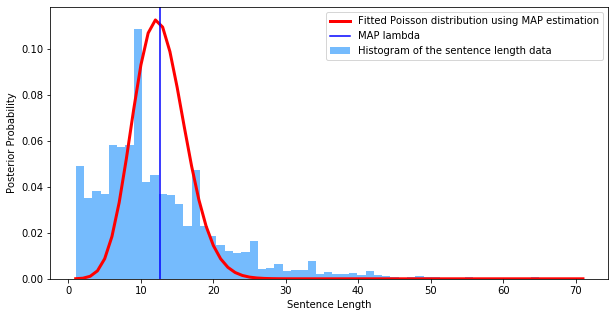

In [12]:
# generate integer values from 1 to 70
x_range = np.linspace(1, 71, 71)
# histogram plot of the sentence length data
plt.hist(data, density=True, bins='auto', label='Histogram of the sentence length data', color='xkcd:sky blue')
# a plot of the fitted poisson distribution using the estimated parameter, lambda_
plt.plot(x_range, ss.poisson.pmf(x_range, mu=MAP_lambda), 'r-', lw=3, 
                                label='Fitted Poisson distribution using MAP estimation')
# indicates the MAP estimation
plt.axvline(MAP_lambda, color='blue', label='MAP lambda')

plt.legend()
# labelling the x and y axes
plt.xlabel('Sentence Length')
plt.ylabel('Posterior Probability')
plt.show()

The difference between the Poisson MLE and MAP distributions is that the MAP lambda (parameter of the posterior) is slightly lower than the MLE lambda.
The lambda parameter of the posterior has been estimated and the output is the posterior probability.